In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import cross_val_score, train_test_split
import numpy as np
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
sales = pd.read_csv("kc_house_data_train.csv", index_col = 0)
holdout = pd.read_csv("kc_house_data_test_features.csv", index_col = 0)
filledrooms = pd.read_csv("bedroomsfilled.csv", index_col = 0)

In [3]:
def filled_data(df,df2):
    index=df.loc[df.bedrooms == 0].index.to_list()
    df.drop(df.index[[index]], inplace=True)
    frames= [df, df2]
    train = pd.concat(frames)
    return train
sales=filled_data(sales,filledrooms)

In [4]:
print(sales.shape)
sales.head()

(17290, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


In [5]:
sales.tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
9286,2954400190,20140624T000000,1295650.0,4,4.50,4810,28008,2.0,0,0,3,12,4810,0,1990,0,98053,47.6642,-122.069,4740,35061
10067,3980300371,20140926T000000,142000.0,1,0.75,290,20875,1.0,0,0,1,1,290,0,1954,0,98024,47.5308,-121.888,1620,22850
10074,2310060040,20140925T000000,240000.0,4,2.50,1810,5669,2.0,0,0,3,7,1810,0,2003,0,98038,47.3493,-122.053,1810,5685
13989,6896300380,20141002T000000,228000.0,2,1.00,390,5900,1.0,0,0,2,4,390,0,1953,0,98118,47.5260,-122.261,2170,6000
15733,7849202299,20150218T000000,320000.0,4,2.50,1490,7111,2.0,0,0,3,7,1490,0,1999,0,98065,47.5261,-121.826,1500,4675


In [6]:
sales["month"] = pd.DatetimeIndex(sales["date"]).month
sales.drop(columns=["id","date"], inplace = True)

In [7]:
# sales["month"] = pd.DatetimeIndex(sales["month"]).month

In [8]:
def filled_data(df,df2):
    index=df.loc[df.bedrooms == 0].index.to_list()
    df.drop(df.index[[index]], inplace=True)
    frames= [df, df2]
    train = pd.concat(frames)
    return train
sales=filled_data(sales,filledrooms)

In [9]:
sales.head()

,bathrooms,bedrooms,condition,date,floors,grade,id,lat,long,month,price,sqft_above,sqft_basement,sqft_living,sqft_living15,sqft_lot,sqft_lot15,view,waterfront,yr_built,yr_renovated,zipcode
0,2.25,4,4,NaN,2.0,8,NaN,47.4388,-122.162,10.0,365000.0,2070,0,2070,2390,8893,7700,0,0,1986,0,98058
1,3.00,5,5,NaN,1.0,8,NaN,47.6784,-122.285,8.0,865000.0,1830,1070,2900,2370,6730,6283,0,0,1977,0,98115
2,2.50,4,3,NaN,2.0,11,NaN,47.5646,-122.129,8.0,1038000.0,3770,0,3770,3710,10893,9685,2,0,1997,0,98006
3,3.50,3,3,NaN,2.0,12,NaN,47.6995,-122.228,3.0,1490000.0,4560,0,4560,4050,14608,14226,2,0,1990,0,98034
4,2.50,3,3,NaN,2.0,9,NaN,47.6647,-122.083,7.0,711000.0,2550,0,2550,2250,5376,4050,0,0,2004,0,98052


In [10]:
max_threshold = sales.price.quantile(.975)
min_threshold = sales.price.quantile(.025)

In [11]:
sales[sales["price"]>max_threshold].shape

(433, 22)

In [12]:
864/17290

0.04997108155002892

In [13]:
sales[sales["price"]<min_threshold].shape

(422, 22)

In [14]:
sales["price"].max()

7700000.0

In [15]:
sales[sales["price"]==7700000.0]

,bathrooms,bedrooms,condition,date,floors,grade,id,lat,long,month,price,sqft_above,sqft_basement,sqft_living,sqft_living15,sqft_lot,sqft_lot15,view,waterfront,yr_built,yr_renovated,zipcode
10366,8.0,6,4,NaN,2.5,13,NaN,47.6298,-122.323,10.0,7700000.0,8570,3480,12050,3940,27600,8800,3,0,1910,1987,98102


In [16]:
sales.describe()

,bathrooms,bedrooms,condition,floors,grade,id,lat,long,month,price,sqft_above,sqft_basement,sqft_living,sqft_living15,sqft_lot,sqft_lot15,view,waterfront,yr_built,yr_renovated,zipcode
count,17302.000000,17302.000000,17302.000000,17302.000000,17302.000000,1.200000e+01,17302.000000,17302.000000,17290.000000,1.730200e+04,17302.000000,17302.000000,17302.000000,17302.000000,1.730200e+04,17302.000000,17302.000000,17302.000000,17302.000000,17302.000000,17302.000000
mean,2.112920,3.374408,3.408045,1.490695,7.653739,4.223658e+09,47.560038,-122.214208,6.570561,5.406641e+05,1789.299445,291.955959,2081.255404,1988.058606,1.525072e+04,12883.600682,0.238585,0.007976,1970.804127,83.748179,98078.188995
std,0.770049,0.936039,0.651489,0.539305,1.176582,2.399537e+09,0.138407,0.140927,3.116999,3.733139e+05,829.606627,443.064932,920.300787,684.993083,4.231757e+04,27266.669031,0.775213,0.088954,29.340891,400.196600,53.598244
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.222029e+09,47.155900,-122.519000,1.000000,7.500000e+04,290.000000,0.000000,290.000000,399.000000,5.720000e+02,659.000000,0.000000,0.000000,1900.000000,0.000000,98001.000000
25%,1.500000,3.000000,3.000000,1.000000,7.000000,2.504640e+09,47.471125,-122.329000,4.000000,3.200000e+05,1200.000000,0.000000,1430.000000,1490.000000,5.080250e+03,5111.000000,0.000000,0.000000,1951.000000,0.000000,98033.000000
50%,2.250000,3.000000,3.000000,1.500000,7.000000,3.646450e+09,47.571500,-122.230000,6.000000,4.500000e+05,1560.000000,0.000000,1920.000000,1840.000000,7.642000e+03,7622.000000,0.000000,0.000000,1974.000000,0.000000,98065.000000
75%,2.500000,4.000000,4.000000,2.000000,8.000000,6.453875e+09,47.677900,-122.125250,9.000000,6.450000e+05,2216.750000,560.000000,2550.000000,2360.000000,1.072575e+04,10101.750000,0.000000,0.000000,1996.000000,0.000000,98118.000000
max,8.000000,33.000000,5.000000,3.500000,13.000000,7.849202e+09,47.777600,-121.315000,12.000000,7.700000e+06,9410.000000,4820.000000,13540.000000,6210.000000,1.651359e+06,858132.000000,4.000000,1.000000,2015.000000,2015.000000,98199.000000


In [17]:
sales.price.max()

7700000.0

In [18]:
sales[sales.price == 7700000.0]

,bathrooms,bedrooms,condition,date,floors,grade,id,lat,long,month,price,sqft_above,sqft_basement,sqft_living,sqft_living15,sqft_lot,sqft_lot15,view,waterfront,yr_built,yr_renovated,zipcode
10366,8.0,6,4,NaN,2.5,13,NaN,47.6298,-122.323,10.0,7700000.0,8570,3480,12050,3940,27600,8800,3,0,1910,1987,98102


In [19]:
zipcode_df=sales.groupby(sales.zipcode)["price","bedrooms","bathrooms","view", "sqft_living", "sqft_lot"].median()

In [20]:
zipcode_df

,price,bedrooms,bathrooms,view,sqft_living,sqft_lot
zipcode,,,,,,
98001,261000.0,3.0,2.000,0.0,1810.0,9287.0
98002,229950.0,3.0,1.750,0.0,1550.0,7265.0
98003,265000.0,3.0,2.250,0.0,1772.5,8806.5
98004,1208000.0,4.0,2.500,0.0,2770.0,11894.0
98005,761225.0,4.0,2.375,0.0,2520.0,12285.0
98006,753000.0,4.0,2.500,0.0,2660.0,10440.0
98007,542250.0,4.0,2.250,0.0,1950.0,8876.0
98008,550000.0,4.0,2.000,0.0,2000.0,8775.0
98010,362500.0,3.0,2.000,0.0,1985.0,19109.0


In [21]:
zipcode_df.price.max()


1892500.0

In [22]:
zipcode_df[zipcode_df.price == 1892500.0] #zipcode 98039 could be the winnder... 

,price,bedrooms,bathrooms,view,sqft_living,sqft_lot
zipcode,,,,,,
98039,1892500.0,4.0,3.0,0.0,3595.0,16818.5


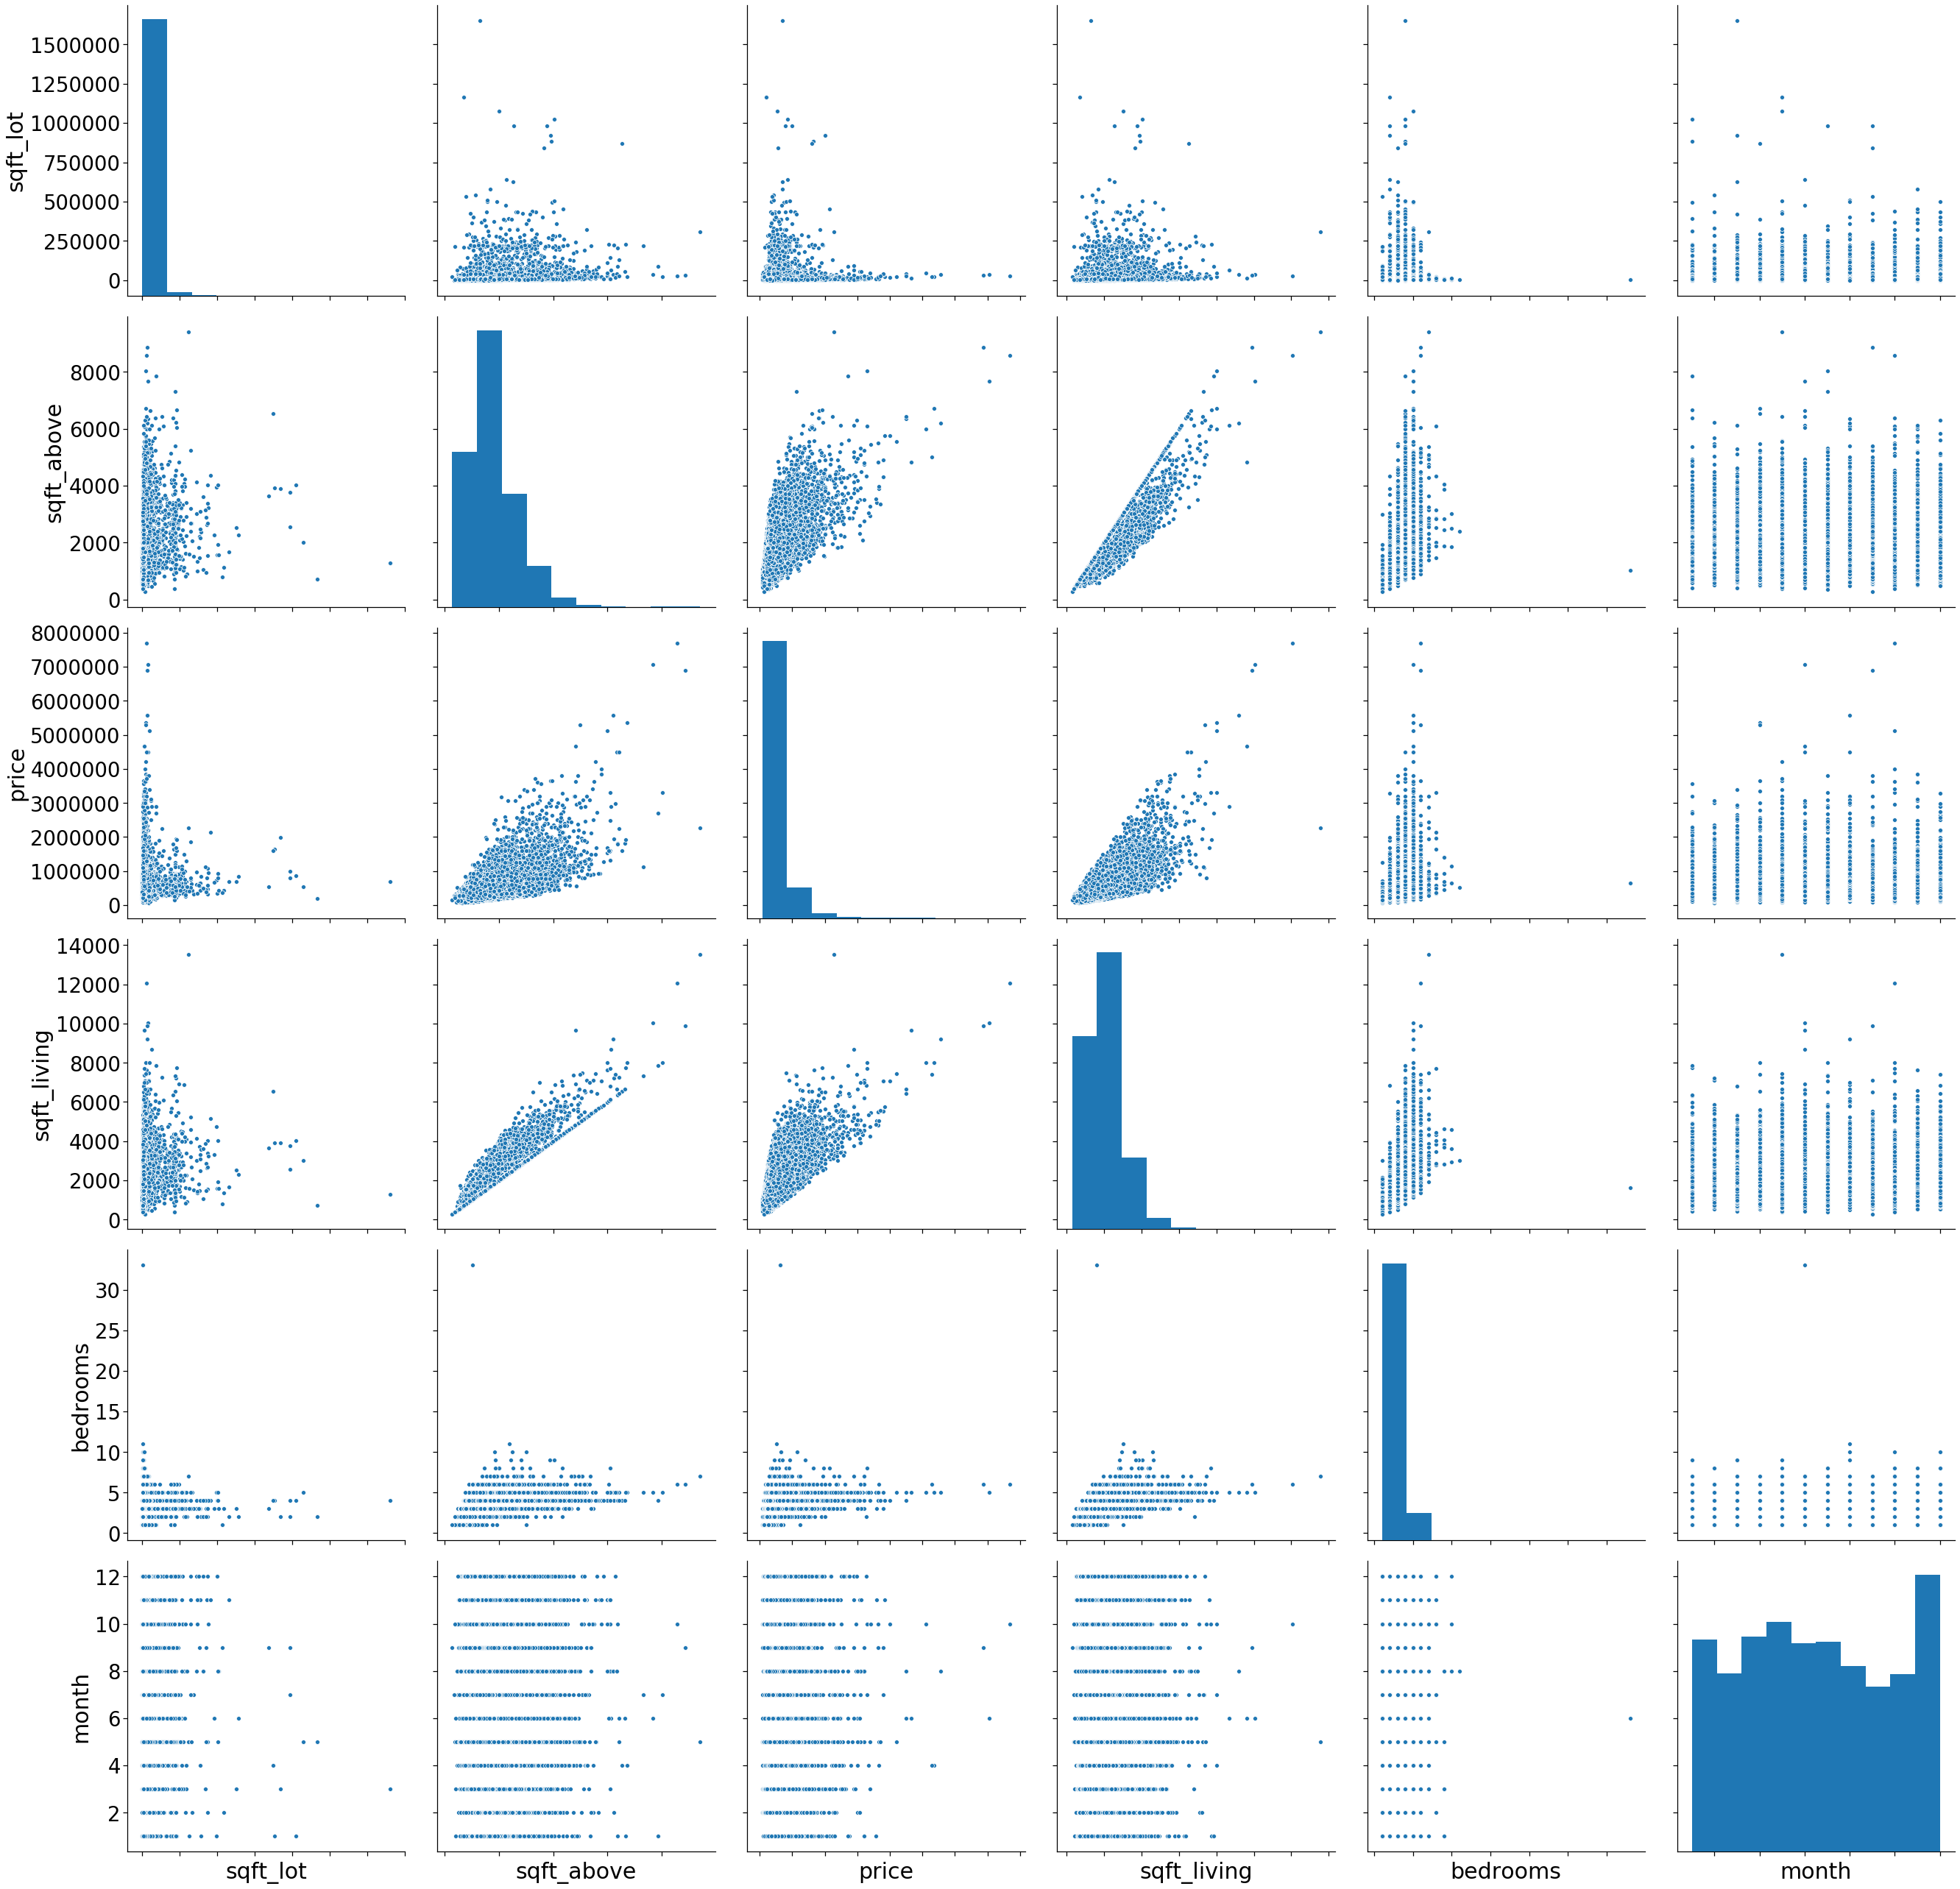

In [23]:
with sns.plotting_context("notebook",font_scale=2.5):
    g = sns.pairplot(sales[['sqft_lot','sqft_above','price','sqft_living','bedrooms', 'month']], size=6)
g.set(xticklabels=[]);

In [24]:
categorical =['bedrooms', 'view', 'waterfront', 'bathrooms', 'floors','condition',
              'grade', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'month']
non_cat = ['sqft_living','sqft_lot','sqft_above', 'sqft_basement','sqft_living15', 'sqft_lot15']
target = "price"
predictor = "Mix of categorical and non categorical"

In [25]:
print(len(categorical))
print(len(non_cat))

13
6


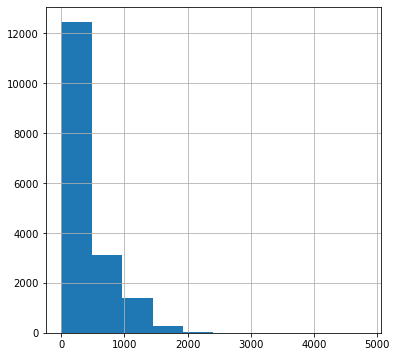

In [26]:
sales["sqft_basement"].hist(figsize  = [6, 6]);

In [27]:
def log_function(data):
    
    
    """ applies np.log to the contineous variables of 
    sqft_above, sqft_living, sqft_living15, sqft_lot, sqft_lot15 
    and returns in a histogram"""
    
    
    data_log = pd.DataFrame([])
    data_log['log_above'] = np.log(data['sqft_above'])
    data_log['log_living'] = np.log(data['sqft_living'])
    data_log['log_living15'] = np.log(data['sqft_living15'])
    data_log['log_lot'] = np.log(data['sqft_lot'])
    data_log['log_lot15'] = np.log(data['sqft_lot15'])
    return data_log.hist(figsize  = [6, 6]);
    

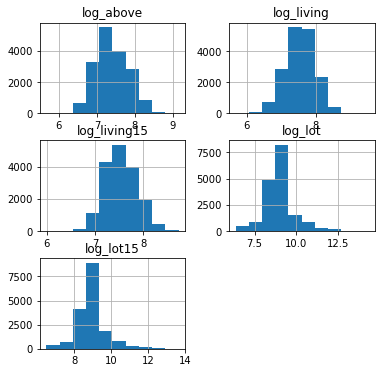

In [28]:
log_function(sales);

In [29]:
data_log = pd.DataFrame([])
data_log['log_above'] = np.log(sales['sqft_above'])
data_log['log_living'] = np.log(sales['sqft_living'])
data_log['log_living15'] = np.log(sales['sqft_living15'])
data_log['log_lot'] = np.log(sales['sqft_lot'])
data_log['log_lot15'] = np.log(sales['sqft_lot15'])


# scaled_above= (log_above - np.mean(log_above)) / np.sqrt(np.var(log_above))
# scaled_living = (log_living - np.mean(log_living)) / np.sqrt(np.var(log_living))
# scaled_lot = (log_lot - np.mean(log_lot)) / np.sqrt(np.var(log_lot))
# scaled_lot15 = (log_lot15 - np.mean(log_lot15)) / (max(log_lot15) - min(log_lot15))

# data_cont_scaled = pd.DataFrame([])
# data_cont_scaled['std_above'] = scaled_above
# data_cont_scaled['std_living'] = scaled_living
# data_cont_scaled['std_lot'] = scaled_lot
# data_cont_scaled['mean_norm_lot15'] = scaled_lot15

waterfront_dummies = pd.get_dummies(sales["waterfront"], prefix="wfront",  drop_first = True)
view_dummies = pd.get_dummies(sales["view"], prefix="view", drop_first = True)
grade_dummies = pd.get_dummies(sales["grade"], prefix="grade",  drop_first = True)
zipcode_dummies = pd.get_dummies(sales["zipcode"], prefix="zipcode",  drop_first = True)
bedroom_dummies = pd.get_dummies(sales["bedrooms"], prefix="rooms",  drop_first = True)
bathroom_dummies = pd.get_dummies(sales["bathrooms"], prefix="bathrooms", drop_first = True)
month_dummies = pd.get_dummies(sales["month"], prefix="month", drop_first = True)
price = sales["price"]

data_fin = pd.concat([price, data_log, waterfront_dummies, view_dummies, grade_dummies,zipcode_dummies, bedroom_dummies, bathroom_dummies, month_dummies], axis=1)



In [30]:
data_fin.shape

(17302, 142)

In [31]:
dropped_price = data_fin.drop(columns = "price")
X = dropped_price.values
y = data_fin.price.values

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2, random_state=42)

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
multi_lr_model = LinearRegression() # model

multi_lr_model.fit(X_train, y_train) # fit

y_pred = multi_lr_model.predict(X_test) # prediction

model_score = multi_lr_model.score(X_test,y_test)
r_square = metrics.r2_score(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
mae = metrics.median_absolute_error(y_test, y_pred)
ev = metrics.explained_variance_score(y_test, y_pred)


print("R Square               : ", r_square)


print("Root Mean Squared Error: ", mse**(1/2))


R Square               :  0.825933422401204
Root Mean Squared Error:  154877.50566666602


In [33]:
# outcome = data_fin.price.values
# predictors = dropped_price.values
# pred_sum = "+".join(predictors)
# formula = outcome + "~" + pred_sum

formula = "price ~ data_log+ waterfront_dummies+view_dummies+grade_dummies+zipcode_dummies+bedroom_dummies+bathroom_dummies+ month_dummies"
model = ols(formula= formula, data=data_fin).fit()
model.summary() 




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     598.1
Date:                Tue, 20 Oct 2020   Prob (F-statistic):               0.00
Time:                        23:55:48   Log-Likelihood:            -2.3116e+05
No. Observations:               17302   AIC:                         4.626e+05
Df Residuals:                   17160   BIC:                         4.637e+05
Df Model:                         141                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -1.962e+06   1.75e+05    -11.182      0.000   -2.31e+06   -1.62e+06
data_log[0]           6.791e+04   6479.293     10.482      0.000    5.52e+04    8.06e+04
data_log[1]           1.864e+05   7737.903     24.094      0.000    1.71e+05    2.02e+05
data_log[2]           4.441e+04   6452.805      6.883      0.000    3.18e+04    5.71e+04
data_log[3]           3.716e+04   3420.396     10.865      0.000    3.05e+04    4.39e+04
data_log[4]          -1.071e+04   3818.504     -2.806      0.005   -1.82e+04   -3229.740
waterfront_dummies    6.033e+05   1.68e+04     35.966      0.000     5.7e+05    6.36e+05
view_dummies[0]       8.804e+04   9821.139      8.965      0.000    6.88e+04    1.07e+05
view_dummies[1]       7.725e+04   5938.890     13.008      0.000    6.56e+04    8.89e+04
view_dummies[2]       1.443e+05   8134.685     17.741      0.000    1.28e+05     1.6e+05
view_dummies[3]       2.894e+05   1.22e+04     23.633      0.000    2.65e+05    3.13e+05
grade_dummies[0]     -4.207e+04   1.68e+05     -0.250      0.803   -3.72e+05    2.88e+05
grade_dummies[1]     -7.075e+04   1.16e+05     -0.610      0.542   -2.98e+05    1.57e+05
grade_dummies[2]       -1.6e+05   1.14e+05     -1.406      0.160   -3.83e+05    6.31e+04
grade_dummies[3]     -1.759e+05   1.14e+05     -1.548      0.122   -3.99e+05    4.68e+04
grade_dummies[4]     -1.837e+05   1.14e+05     -1.616      0.106   -4.07e+05    3.92e+04
grade_dummies[5]     -1.586e+05   1.14e+05     -1.394      0.163   -3.82e+05    6.45e+04
grade_dummies[6]     -7.022e+04   1.14e+05     -0.616      0.538   -2.94e+05    1.53e+05
grade_dummies[7]      6.796e+04   1.14e+05      0.596      0.551   -1.56e+05    2.92e+05
grade_dummies[8]      2.928e+05   1.14e+05      2.559      0.011    6.85e+04    5.17e+05
grade_dummies[9]      7.167e+05   1.16e+05      6.183      0.000    4.89e+05    9.44e+05
grade_dummies[10]     1.716e+06   1.27e+05     13.532      0.000    1.47e+06    1.96e+06
zipcode_dummies[0]    2.155e+04   1.54e+04      1.396      0.163   -8697.437    5.18e+04
zipcode_dummies[1]    1588.7271   1.38e+04      0.115      0.908   -2.55e+04    2.86e+04
zipcode_dummies[2]    8.099e+05   1.38e+04     58.664      0.000    7.83e+05    8.37e+05
zipcode_dummies[3]    3.247e+05   1.61e+04     20.202      0.000    2.93e+05    3.56e+05
zipcode_dummies[4]    2.791e+05   1.23e+04     22.709      0.000    2.55e+05    3.03e+05
zipcode_dummies[5]    2.715e+05   1.68e+04     16.188      0.000    2.39e+05    3.04e+05
zipcode_dummies[6]    2.837e+05   1.38e+04     20.530      0.000    2.57e+05    3.11e+05
zipcode_dummies[7]    6.081e+04   2.02e+04      3.008      0.003    2.12e+04       1e+05
zipcode_dummies[8]    1.461e+05   1.52e+04      9.607      0.000    1.16e+05    1.76e+05
zipcode_dummies[9]     8.15e+04   1.81e+04      4.501    

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(X_train, y_train)
y_hat =lr.predict(X_test)
RMSE = mean_squared_error(y_test, y_hat)
print(np.sqrt(RMSE))

154877.50566666602
